# 千帆视觉语言模型（Qianfan-VL）使用指南

## 千帆多模态大模型的训练方法

千帆多模态大模型采用了两大核心训练方法来提升模型性能：

### 领域数据增强的图文对齐
- 基于超过1T的tokens进行持续预训练，有效复用千帆文本语言模型和开源视觉编码器
- 采用多阶段训练技术，实现单图、多图、视频和文本等多种模态信息的理解能力
- 利用海量互联网图文数据，挖掘信息密度高的内容，包括多尺度分辨率的图片和文档
- 进行细粒度的图文对齐训练，提升模型对视觉内容的理解精度

### 复杂指令增强
- 针对企业级用户场景化的复杂需求，进行特定的指令增强微调
- 强化多模态理解模型对复杂指令的处理能力
- 提升模型在实际业务场景中的应用效果

通过这两大核心训练方法，千帆多模态大模型在图像理解、多模态内容生成和复杂场景处理等方面都表现出色，为各行业用户提供强大的AI能力支持。

## 千帆视觉语言模型单图调用示例

下面展示如何使用千帆视觉语言模型处理单张图片并获取分析结果：

In [7]:
import base64
import requests
import os
from IPython.display import Image, display

### 设置API密钥和模型参数

请先设置您的API密钥，可以从环境变量读取或直接输入：

In [28]:
# 设置API密钥（从环境变量获取或直接设置）
API_KEY = os.environ.get("QIANFAN_TOKEN", "")
# 如果环境变量中没有，请直接设置
if not API_KEY:
    API_KEY = ""  # 替换为您的API密钥

# 设置模型ID和API端点
MODEL_ID = "qianfan-llama-vl-8b"
ENDPOINT = "https://qianfan.baidubce.com/v2/chat/completions"

### 设置图片路径和查询提示

指定要分析的图片路径和提示文本：

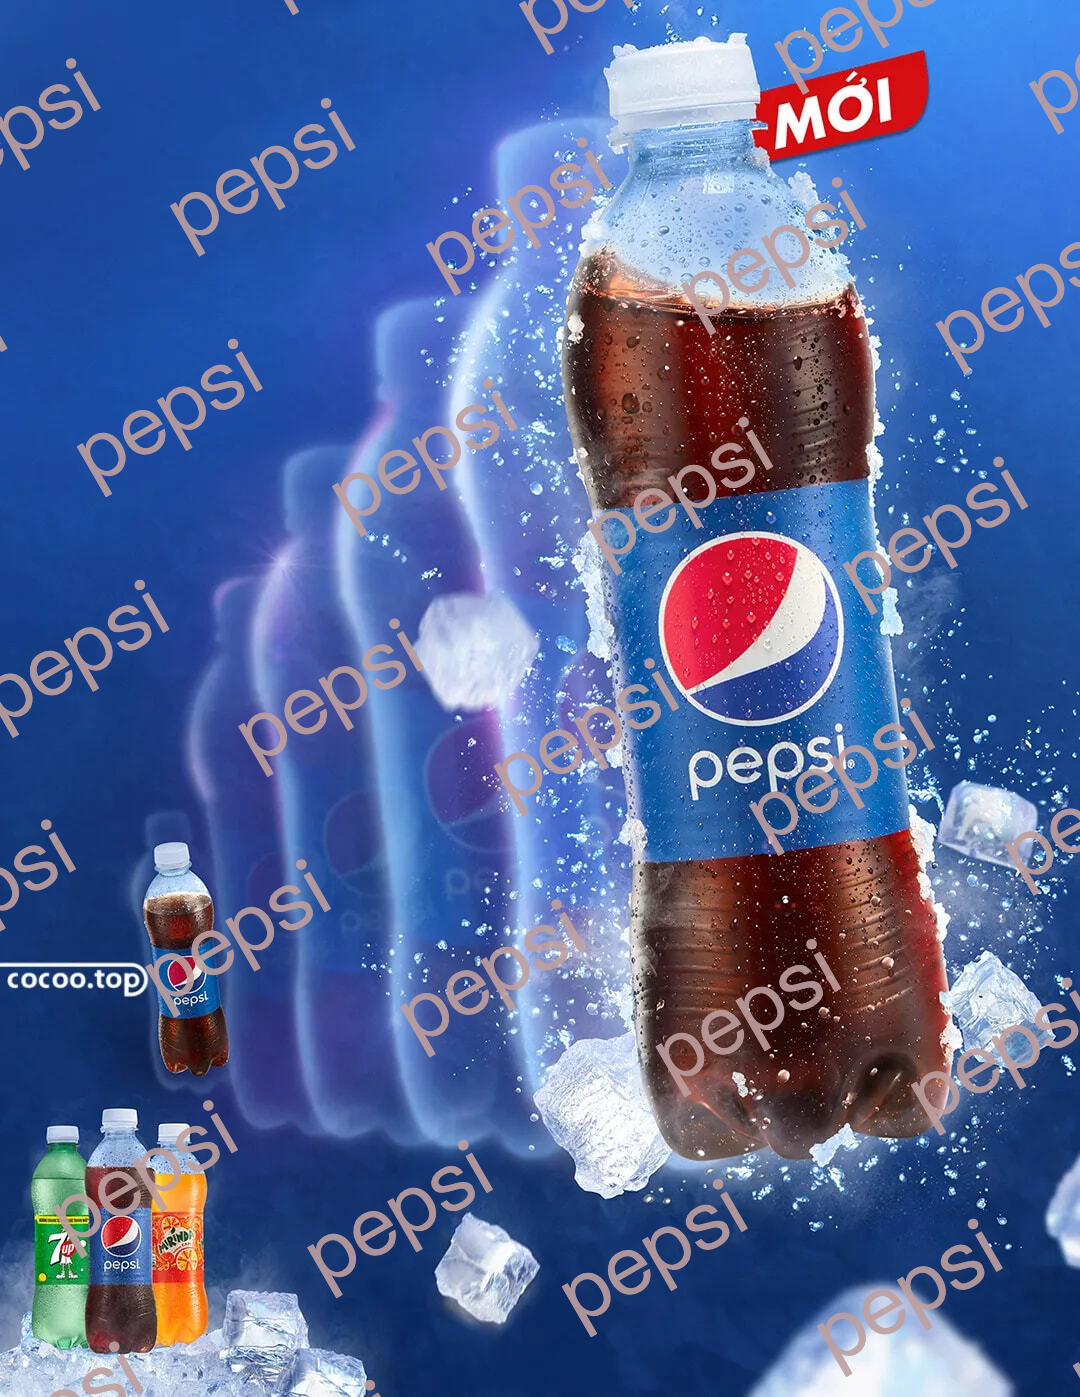

In [9]:
# 设置图片路径
IMAGE_PATH = "../images/电商图.jpg"  # 修改为您要使用的图片路径

# 显示要分析的图片
try:
    display(Image(filename=IMAGE_PATH))
except Exception as e:
    print(f"无法显示图片: {e}")

# 设置查询提示
QUERY = """
你是电商图片质检专家。请对我提供的商品图片，按以下标准检查：水印、阴影、抠图瑕疵、AIGC痕迹、清晰度、色彩真实性、比例、边框、暗角、曝光、色块等。仅输出一个JSON，字段为'result'，列出所有发现的问题，无问题则输出'正常'。
"""

### 图像编码和API调用函数

In [10]:
def encode_image(image_path):
    """将图像编码为Base64格式"""
    try:
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode("utf-8")
    except Exception as e:
        print(f"图像编码失败: {e}")
        return None

def call_qianfan_api(image_path, query, model_id=MODEL_ID, api_key=API_KEY):
    """调用千帆API处理图像
    
    参数:
        image_path: 可以是单个图片路径(字符串)或多个图片路径的列表
        query: 查询文本
        model_id: 模型ID
        api_key: API密钥
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    content = []
    
    # 将单个图片路径转换为列表，以便统一处理
    if isinstance(image_path, str):
        image_paths = [image_path]
    else:
        image_paths = image_path
    
    # 添加所有图像
    for img_path in image_paths:
        if os.path.exists(img_path):
            base64_image = encode_image(img_path)
            if base64_image:
                image_content = {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }

                content.append(image_content)
                print(f"已添加图片: {img_path}")
            else:
                print(f"图像编码失败: {img_path}")
        else:
            print(f"图像文件不存在: {img_path}")
    
    # 添加文本查询
    content.append({"type": "text", "text": query})

    # 准备请求
    payload = {
        "model": model_id,
        "messages": [{"role": "user", "content": content}],
    }
    
    print(f"发送请求到: {ENDPOINT}")
    print(f"使用模型: {model_id}")
    
    try:
        # 发送请求
        print("正在发送请求...")
        response = requests.post(
            ENDPOINT,
            json=payload,
            headers=headers
        )
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"API调用失败: {e}")
        if hasattr(response, "text"):
            print(f"响应内容: {response.text}")
        return None

### 执行API调用并获取结果

In [11]:
# 调用API并获取结果
result = call_qianfan_api(IMAGE_PATH, QUERY)

# 解析并显示结果
if result:
    try:
        response_content = result.get("choices", [{}])[0].get("message", {}).get("content", "")
        print("\n模型响应:")
        print(response_content)
    except Exception as e:
        print(f"解析响应失败: {e}")
        print("原始响应:")
        print(result)

已添加图片: ../images/电商图.jpg
发送请求到: https://qianfan.baidubce.com/v2/chat/completions
使用模型: qianfan-llama-vl-8b
正在发送请求...

模型响应:
```json
{
  "result": [
    "水印",
    "抠图瑕疵"
  ]
}
```


### 其他应用场景示例

除了电商图片质检外，千帆视觉语言模型还可用于多种场景，只需修改提示词即可：

In [12]:
# 场景示例：图片内容详细描述
description_query = "请详细描述这张图片中的内容，包括主体、背景、色彩和可能的用途。"

# 场景示例：图片安全检测
safety_query = "请评估这张图片是否含有不适宜内容，包括但不限于暴力、血腥、色情等元素。"

# 场景示例：OCR文字识别
ocr_query = "请识别并提取图片中的所有文字内容。"

# 取消注释并运行以下代码执行特定场景的API调用
result = call_qianfan_api(IMAGE_PATH, description_query)
response_content = result.get("choices", [{}])[0].get("message", {}).get("content", "")
print("\n模型响应:")
print(response_content)
result = call_qianfan_api(IMAGE_PATH, safety_query)
response_content = result.get("choices", [{}])[0].get("message", {}).get("content", "")
print("\n模型响应:")
print(response_content)
result = call_qianfan_api(IMAGE_PATH, ocr_query)
response_content = result.get("choices", [{}])[0].get("message", {}).get("content", "")
print("\n模型响应:")
print(response_content)

已添加图片: ../images/电商图.jpg
发送请求到: https://qianfan.baidubce.com/v2/chat/completions
使用模型: qianfan-llama-vl-8b
正在发送请求...

模型响应:
这张图片展示了一个大型Pepsi（百事可乐）瓶，瓶身呈棕色，带有标志性的蓝色和红色条纹。瓶身周围有冰块和水珠，营造出清凉的感觉。背景是蓝色的，带有Pepsi品牌水印。图片右下角还展示了三种不同口味的Pepsi产品：7up、Mirinda和Wild Cherry。整体设计突出了Pepsi品牌的清凉形象和多种口味选择。这类广告图通常用于促销、社交媒体宣传或产品目录中，目的是吸引消费者注意并推广Pepsi的各种饮料产品。
已添加图片: ../images/电商图.jpg
发送请求到: https://qianfan.baidubce.com/v2/chat/completions
使用模型: qianfan-llama-vl-8b
正在发送请求...

模型响应:
这张图片展示的是一瓶Pepsi（百事可乐）饮料，周围有冰块和水珠，背景是蓝色的。图片中没有任何暴力、血腥或色情元素。这是一张典型的饮料广告图片，展示了清凉的视觉效果，可能用于夏季营销活动。
已添加图片: ../images/电商图.jpg
发送请求到: https://qianfan.baidubce.com/v2/chat/completions
使用模型: qianfan-llama-vl-8b
正在发送请求...

模型响应:
图片中的文字内容有：

1. "pepsi"（多次重复出现，作为品牌水印）
2. "pepsi moi"（位于图片上方中央位置，似乎是广告语的一部分）
3. "cocoo.top"（位于图片左下角）

图片展示了一瓶Pepsi饮料和一些小包装饮料，背景是蓝色的，周围有水珠和冰块效果，整体呈现出清凉的感觉。


## 千帆视觉语言模型多图和文件调用示例

下面展示如何使用千帆视觉语言模型处理多张图片并获取分析结果：

### 设置多个图片路径和查询提示

指定要分析的图片路径和提示文本：

In [20]:
image_paths = ["../images/17-软硬件服务协议_page-0001.jpg", "../images/17-软硬件服务协议_page-0002.jpg",
               "../images/17-软硬件服务协议_page-0003.jpg", "../images/17-软硬件服务协议_page-0004.jpg"]
query = "我是甲方, 应向乙方付多少钱"
# 创建简单的HTML表格
html = '<table><tr><td>'
html += '</td><td>'.join([f'<img src="{img}" width="400px">' for img in image_paths[:2]])
html += '</td></tr><tr><td>'
html += '</td><td>'.join([f'<img src="{img}" width="400px">' for img in image_paths[2:]])
html += '</td></tr></table>'
from IPython.display import HTML
display(HTML(html))


,
,


#### 执行API调用并获取结果

In [19]:
# 调用API并获取结果
result = call_qianfan_api(image_paths, query)

# 解析并显示结果
if result:
    try:
        response_content = result.get("choices", [{}])[0].get("message", {}).get("content", "")
        print("\n模型响应:")
        print(response_content)
    except Exception as e:
        print(f"解析响应失败: {e}")
        print("原始响应:")
        print(result)

已添加图片: ../images/17-软硬件服务协议_page-0001.jpg
已添加图片: ../images/17-软硬件服务协议_page-0002.jpg
已添加图片: ../images/17-软硬件服务协议_page-0003.jpg
已添加图片: ../images/17-软硬件服务协议_page-0004.jpg
发送请求到: https://qianfan.baidubce.com/v2/chat/completions
使用模型: qianfan-llama-vl-8b
正在发送请求...

模型响应:
2,702,500元


### 也可直接通过输入文件调用

#### 定义文件处理函数

In [5]:
import fitz
import tempfile
import os
def convert_pdf_to_images(pdf_path):
    """将PDF转换为图像列表，使用PyMuPDF (fitz)"""
    print(f"正在将PDF转换为图像: {pdf_path}")
    
    # 打开PDF文件
    pdf_document = fitz.open(pdf_path)
    print(f"PDF共有 {len(pdf_document)} 页")
    
    # 创建临时目录存储图像
    temp_dir = tempfile.mkdtemp()
    temp_image_paths = []
    
    # 为每一页生成图像
    for page_num in range(len(pdf_document)):
        # 获取页面
        page = pdf_document[page_num]
        
        # 设置渲染参数（较高分辨率以获得更好的质量）
        zoom_x = 2.0  # 水平缩放
        zoom_y = 2.0  # 垂直缩放
        matrix = fitz.Matrix(zoom_x, zoom_y)
        
        # 渲染页面为像素图（pixmap）
        pixmap = page.get_pixmap(matrix=matrix)
        
        # 保存为图像文件
        temp_image_path = os.path.join(temp_dir, f"page_{page_num+1}.jpg")
        pixmap.save(temp_image_path)
        temp_image_paths.append(temp_image_path)
    
    # 关闭PDF文档
    pdf_document.close()
    
    return temp_image_paths

#### 定义文件路径和提示文本

In [27]:
file_path = "../images/17-软硬件服务协议.pdf"
query = "我是甲方, 应向乙方付多少钱"

#### 执行API调用并获取结果

In [14]:
image_paths = convert_pdf_to_images(file_path)
result = call_qianfan_api(image_paths, query)
# 解析并显示结果
if result:
    try:
        response_content = result.get("choices", [{}])[0].get("message", {}).get("content", "")
        print("\n模型响应:")
        print(response_content)
    except Exception as e:
        print(f"解析响应失败: {e}")
        print("原始响应:")
        print(result)
for image_path in image_paths:
    if os.path.exists(image_path):
        os.remove(image_path)

正在将PDF转换为图像: ../images/17-软硬件服务协议.pdf
PDF共有 4 页
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmpmrdhh8vs/page_1.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmpmrdhh8vs/page_2.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmpmrdhh8vs/page_3.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmpmrdhh8vs/page_4.jpg
发送请求到: https://qianfan.baidubce.com/v2/chat/completions
使用模型: qianfan-llama-vl-8b
正在发送请求...

模型响应:
2,702,500元


## 千帆视觉语言模型视频调用示例 

下面展示如何使用千帆视觉语言模型处理视频并获取分析结果：

### 定义视频处理函数

In [17]:
import cv2
import numpy as np
from PIL import Image

def extract_frames_from_video(video_path):
    """从视频中提取帧，使用OpenCV"""
    print(f"正在从视频中提取帧: {video_path}")
    
    # 硬编码设置为8帧
    num_frames = 8
    
    # 使用OpenCV打开视频
    video = cv2.VideoCapture(video_path)
    
    # 获取视频的总帧数
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        print("无法读取视频帧")
        video.release()
        return []
    
    print(f"视频总帧数: {total_frames}")
    
    # 创建临时目录存储图像
    temp_dir = tempfile.mkdtemp()
    temp_image_paths = []
    
    # 均匀抽取帧
    if total_frames < num_frames:
        # 如果视频帧数少于指定帧数，则全部使用
        indices = list(range(total_frames))
    else:
        # 均匀抽取指定数量的帧
        indices = np.linspace(0, total_frames-1, num=num_frames, dtype=int)
    
    # 提取并保存帧
    for i, frame_idx in enumerate(indices):
        # 设置读取位置
        video.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = video.read()
        
        if success:
            # OpenCV以BGR格式读取，需要转换为RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            img = Image.fromarray(frame_rgb)
            
            # 保存为JPEG文件
            temp_image_path = os.path.join(temp_dir, f"frame_{i+1}.jpg")
            img.save(temp_image_path, "JPEG", quality=90)
            temp_image_paths.append(temp_image_path)
        else:
            print(f"帧 {frame_idx} 读取失败")
    
    # 释放视频资源
    video.release()
    
    print(f"已提取 {len(temp_image_paths)} 帧")
    return temp_image_paths

### 定义视频路径和提示文本


In [1]:
video_path = "../images/01e79392d907011701037003949ab72e66_4610.mp4video.MP4"
query = "视频中的小鸟在做什么"

### 执行API调用并获取结果

In [23]:
video_path = "../images/01e79392d907011701037003949ab72e66_4610.mp4video.MP4"
query = "详细描述视频中的小鸟在做什么"
image_paths = extract_frames_from_video(video_path)
result = call_qianfan_api(image_paths, query)
# 解析并显示结果
if result:
    try:
        response_content = result.get("choices", [{}])[0].get("message", {}).get("content", "")
        print("\n模型响应:")
        print(response_content)
    except Exception as e:
        print(f"解析响应失败: {e}")
        print("原始响应:")
        print(result)
for image_path in image_paths:
    if os.path.exists(image_path):
        os.remove(image_path)

正在从视频中提取帧: ../images/01e79392d907011701037003949ab72e66_4610.mp4video.MP4
视频总帧数: 2808
已提取 8 帧
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmp7tf97nte/frame_1.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmp7tf97nte/frame_2.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmp7tf97nte/frame_3.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmp7tf97nte/frame_4.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmp7tf97nte/frame_5.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmp7tf97nte/frame_6.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmp7tf97nte/frame_7.jpg
已添加图片: /var/folders/q0/p1rb4vm97vq1x385f0j5mzk40000gn/T/tmp7tf97nte/frame_8.jpg
发送请求到: https://qianfan.baidubce.com/v2/chat/completions
使用模型: qianfan-llama-vl-8b
正在发送请求...

模型响应:
这只鸟正站立在地面上，展开翅膀，呈现出一种展示的姿态。它的羽毛主要为白色和棕色相间，头部为黑色，喙部细长尖锐。周围环境是红褐色的土壤或地面，背景较为模糊，无法辨识更多细节。这只鸟可能是在进行某种展示行为，如求偶炫耀或领地宣示。


## 示例文件来源说明
 
本项目所使用的示例文件，均来自公开渠道或产品开放示例，具体来源如下：

- **单图示例**
  - 来源：百度图片搜索
  - 说明：选取商品广告图片，通过添加水印方式生成测试样例
  - [原图链接](https://image.baidu.com/search/detail?z=0&word=%E5%95%86%E5%93%81%E5%B9%BF%E5%91%8A%E5%9B%BE&hs=0&pn=2&spn=0&di=7482437761027276801&pi=0&rn=1&tn=baiduimagedetail&is=0%2C0&ie=utf-8&oe=utf-8&lm=&cs=4290327675%2C2350604706&os=1732109231%2C503252282&simid=4290327675%2C2350604706&adpicid=0&lpn=0&fr=click-pic&fm=&ic=&hd=&latest=&copyright=&isImgSet=&commodity=&hot=&imgratio=&imgformat=&sme=&width=0&height=0&cg=&bdtype=0&oriquery=&objurl=https%3A%2F%2Fimg.shangyexinzhi.com%2Fxztest-image%2Farticle%2F0a570d0c98ae35d5afe511aa888158f6.jpeg&fromurl=ippr_z2C%24qAzdH3FAzdH3Fooo_z%26e3Bfiwg2yjxtgzit_z%26e3Bv54AzdH3Fw6ptvsjAzdH3F9nld0l8_z%26e3Bip4s&gsm=1e&islist=&querylist=&lid=8142711382075932605)

- **多图及其源文件示例**
  - 来源：百度智能云能力引擎 - 合同审查产品示例
  - 说明：采集自官方公开的合同审查产品示例文件，用于多图及文件输入场景测试
  - [原文件链接](https://console.bce.baidu.com/textmind/application/textReview/sampleTask)

- **视频示例**
  - 来源：小红书平台
  - 说明：视频素材采集自小红书平台鸟类实拍相关公开视频，仅用于演示和测试
  - [原视频链接](https://www.xiaohongshu.com/explore/67939381000000001801a04e?source=webshare&xhsshare=pc_web&xsec_token=AB9qDRPkazQ3OsGR6f3ZUKFeQPV8CNhVUAfTKNPZi3_m0=&xsec_source=pc_share)

> 以上示例文件仅用于功能演示与测试，版权归原作者所有, 若涉及版权问题，请联系删除。